In [1]:
import numpy as np
import pandas as pd
import json

In [5]:
df = pd.read_csv('training_data.csv')

out=[]

# Iterating through the columns of 
# dataframe

for column in df.columns:
    
    # Storing the rows of a column 
    # into a temporary list
    li = df[column].tolist()
    
    # appending the temporary list
    out.append(li) 
    
# Printing the final list

In [6]:
with open('hackathon_public.json', 'r') as f:
    data_list = json.load(f)
    

circuits = data_list['circuits']
results = data_list['results']
files = []
circ={}
families = []
for x in range(len(circuits)):
    files.append(circuits[x]['file'])
    families.append(circuits[x]['family'])


id = {cat: i for i, cat in enumerate(np.unique(families).tolist())}
file_id = {cat: i for i, cat in enumerate(np.unique(files).tolist())}
backend = {cat: i for i, cat in enumerate(['GPU', 'CPU'])}
precision = {cat: i for i, cat in enumerate(['single', 'double'])}


for x in range(len(circuits)):
    circ[x] = ([id[circuits[x]['family']], circuits[x]['n_qubits']])


y = []
new_y = []
file_forward = []
stat_x = []
for x in range(len(results)):
    if results[x]['status'] == 'ok':
        stat_x.append([file_id[results[x]['file']],backend[results[x]['backend']], precision[results[x]['precision']]])
        y.append(results[x]['forward']['threshold'])
        new_y.append(results[x]['forward']['run_wall_s'])

count = 0
for stat in stat_x:
    for file in files:
        if stat[0] == file_id[file]:
            stat.extend(circ[file_id[file]])
            count+=1

res = out
for i in range(len(res[0])):
    res[0][i] = file_id[res[0][i]]

for i in range(len(res[1])):
    res[1][i] = id[res[1][i]]

for i in range(len(res[2])):
    res[2][i] = backend[res[2][i]]

for i in range(len(res[3])):
    res[3][i] = precision[res[3][i]]

X = np.array(res).T.astype(int).tolist()
len(X)


137

In [15]:
def print_predictions(y_true, y_pred, n=10):
    print(" Actual\t\tPredicted\tError")
    print("-" * 40)
    for i in range(min(n, len(y_true))):
        err = y_pred[i] - y_true[i]
        print(f"{y_true[i]:.6f}\t{y_pred[i]:.6f}\t{err:+.6f}")

In [17]:
import matplotlib.pyplot as plt

def plot_percent_error_vs_actual(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    percent_error = 100 * (y_pred - y_true) / np.maximum(y_true, 1e-8)

    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, percent_error, alpha=0.4)
    plt.axhline(0, linestyle='--')
    plt.xlabel("Actual Time")
    plt.ylabel("Percentage Error (%)")
    plt.title("Percentage Error vs Actual Time")
    plt.grid(True)
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
np.random.seed(20)

x_train, x_test, y_train, y_test = train_test_split(
X, new_y, test_size=0.4, random_state=5
)

x_train = np.array(x_train)
y_train = np.array(y_train)



In [10]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(np.array(x_train), y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rf_preds = rf.predict(np.array(x_test))

r2 = r2_score(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest R² : {r2:.4f}")
print(f"Random Forest MAE: {mae:.6f}")
print(f"Random Forest RMSE: {rmse:.6f}")


Random Forest R² : 0.8997
Random Forest MAE: 16.962286
Random Forest RMSE: 50.824572


In [12]:
y_train_log = np.log1p(y_train)  # log(1 + time)
y_test_log  = np.log1p(y_test)

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=2,
    subsample=0.9,
    random_state=42
)

gbr.fit(np.array(x_train), np.array(y_train_log))

,loss,'squared_error'
,learning_rate,0.03
,n_estimators,1000
,subsample,0.9
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


In [14]:
gbr_preds = gbr.predict(np.array(x_test))

r2 = r2_score(y_test, np.expm1(gbr_preds))
mae = mean_absolute_error(y_test, np.expm1(gbr_preds))
rmse = np.sqrt(mean_squared_error(y_test, np.expm1(gbr_preds)))

print(f"GBR R²  : {r2:.4f}")
print(f"GBR MAE : {mae:.6f}")
print(f"GBR RMSE: {rmse:.6f}")

GBR R²  : 0.9066
GBR MAE : 13.422134
GBR RMSE: 49.044436


In [16]:
print_predictions(y_test, np.expm1(gbr_preds), n=10)

 Actual		Predicted	Error
----------------------------------------
0.991824	1.749867	+0.758043
508.986028	307.442036	-201.543992
78.027958	77.165828	-0.862130
6.279502	6.538032	+0.258530
1.138717	2.038197	+0.899480
225.970157	248.237015	+22.266857
4.071834	4.510081	+0.438247
27.040458	27.690726	+0.650268
8.433105	8.209395	-0.223709
219.186942	229.550840	+10.363898


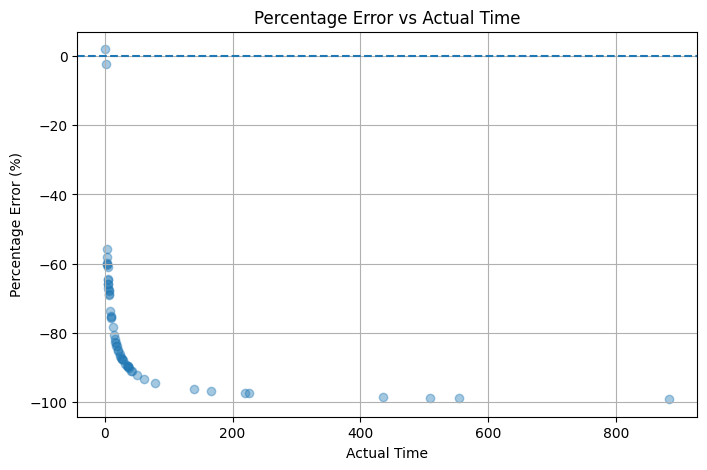

In [18]:
plot_percent_error_vs_actual(y_test, gbr_preds)

In [19]:
import numpy as np
from xgboost import XGBRegressor

x_train_np = np.array(x_train)
x_test_np  = np.array(x_test)
y_train_np = np.array(y_train_log)
y_test_np  = np.array(y_test)

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.07,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(x_train_np, y_train_np)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
xgb_preds = xgb.predict(x_test_np)
r2 = r2_score(y_test_np, np.expm1(xgb_preds))
mae = mean_absolute_error(y_test_np, np.expm1(xgb_preds))
rmse = np.sqrt(mean_squared_error(y_test_np, np.expm1(xgb_preds)))

print(f"XGB R²   : {r2:.4f}")
print(f"XGB MAE  : {mae:.6f}")
print(f"XGB RMSE : {rmse:.6f}")

XGB R²   : 0.9314
XGB MAE  : 13.672367
XGB RMSE : 42.034209


In [21]:
print_predictions(y_test, np.expm1(xgb_preds), n=10)

 Actual		Predicted	Error
----------------------------------------
0.991824	1.936465	+0.944641
508.986028	383.224762	-125.761261
78.027958	88.537880	+10.509926
6.279502	6.528220	+0.248718
1.138717	2.284749	+1.146032
225.970157	182.958862	-43.011292
4.071834	4.407051	+0.335217
27.040458	29.768246	+2.727787
8.433105	8.226176	-0.206928
219.186942	200.766251	-18.420685


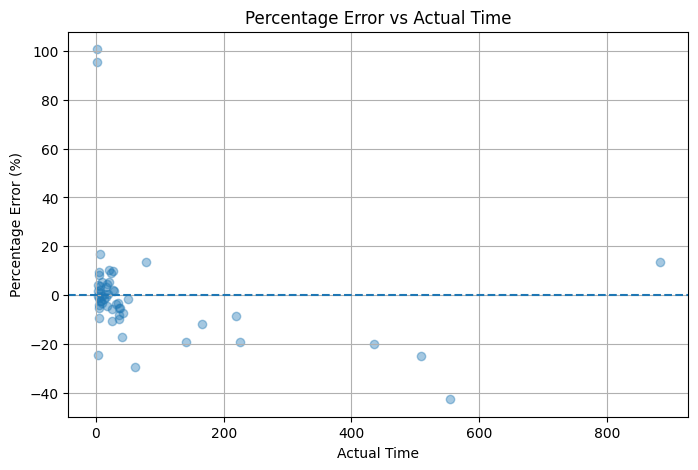

In [22]:
plot_percent_error_vs_actual(y_test, np.expm1(xgb_preds))

In [23]:
to_file = {v: k for k, v in file_id.items()}

df_gbr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(gbr_preds),
    "circuit": x_test_np[:, 0]
})

df_xgb = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(xgb_preds),
    "circuit": x_test_np[:, 0]
})

df_gbr["circuit_name"] = df_gbr["circuit"].map(to_file)
df_xgb["circuit_name"] = df_xgb["circuit"].map(to_file)

df_gbr["percent_error"] = 100 * (df_gbr["predicted"] - df_gbr["actual"]) / np.maximum(df_gbr["actual"], 1e-8)

df_gbr["percent_error"] = 100 * (df_gbr["predicted"] - df_gbr["actual"]) / np.maximum(df_gbr["actual"], 1e-8)

df_xgb["percent_error"] = 100 * (df_xgb["predicted"] - df_xgb["actual"]) / np.maximum(df_xgb["actual"], 1e-8)

df_xgb["percent_error"] = 100 * (df_xgb["predicted"] - df_xgb["actual"]) / np.maximum(df_xgb["actual"], 1e-8)



In [24]:
import altair as alt

base_plot = alt.Chart(df_gbr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("percent_error:Q", title="Percentage Error (%)"),
    tooltip=["actual", "predicted", "percent_error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="GBR Percentage Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart = base_plot + zero_line


In [25]:


base_plot = alt.Chart(df_xgb).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("percent_error:Q", title="Percentage Error (%)"),
    tooltip=["actual", "predicted", "percent_error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="XGB Percentage Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart2 = base_plot + zero_line

chart | chart2


alt.HConcatChart(...)

In [26]:
df_gerr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(gbr_preds),
    "circuit": x_test_np[:, 0]
})

df_xerr = pd.DataFrame({
    "actual": y_test,
    "predicted": np.expm1(xgb_preds),
    "circuit": x_test_np[:, 0]
})


df_gerr["circuit_name"] = df_gbr["circuit"].map(to_file)
df_xerr["circuit_name"] = df_xgb["circuit"].map(to_file)

df_gerr["error"] = df_gerr["predicted"] - df_gerr["actual"]
df_xerr["error"] = df_xerr["predicted"] - df_xerr["actual"]




In [ ]:

base_plot = alt.Chart(df_gerr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("error:Q", title="Error (%)"),
    tooltip=["actual", "predicted", "error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="GBR Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart = base_plot + zero_line


In [28]:
base_plot = alt.Chart(df_xerr).mark_circle(size=40, opacity=0.4).encode(
    x=alt.X("actual:Q", title="Actual Time"),
    y=alt.Y("error:Q", title="Error (%)"),
    tooltip=["actual", "predicted", "error", "circuit_name"]
).properties(
    width=350,
    height=300,
    title="XGB Error vs Actual Time"
)

zero_line = alt.Chart(pd.DataFrame({"y": [0]})).mark_rule(
    strokeDash=[4,4]
).encode(
    y="y:Q"
)

chart2 = base_plot + zero_line

chart | chart2


alt.HConcatChart(...)